In [1]:
import numpy as np
from scipy import linalg as la
from scipy import signal as sl

from matplotlib import pyplot as plt
%matplotlib inline

import pandas as pd
import seaborn as sns

from ase.units import GPa, kB, fs, Bohr
from vibes.konstanten import omega_to_THz
from vibes.trajectory import reader
from vibes.helpers.plotting import tableau_colors as tc

from vibes.io import read
from vibes.helpers.lattice import fractional
from vibes.harmonic_analysis.displacements import get_dR
from vibes.harmonic_analysis import parse_tdep_forceconstant, HarmonicAnalysis
from vibes.helpers.supercell import map_indices

from vibes.helpers.brillouinzone import get_bands_and_labels, get_special_points, get_paths

In [2]:
primitive = read('infile.ucposcar', format='vasp')
supercell = read('infile.ssposcar', format='vasp')
fcs, lps = parse_tdep_forceconstant('outfile.forceconstant')
ha = HarmonicAnalysis(primitive, supercell, fcs, lps)

Parse force constants from
  outfile.forceconstant
.. remap representation for supercell:  False
.. Number of atoms:   2
.. Real space cutoff: 3.660 \AA
.. Number of lattice points: 54 (33 unique)
.. time elapsed: 0.002s
Set up harmonic analysis for MgO:
.. found 32 (31) lattice points in 0.001s
.. time elapsed: 0.065s


In [3]:
# parser of reduced forceconstant
def read_force_constants_and_lattice_points_tdep(file='outfile.forceconstants', verbose=False):
    with open('outfile.forceconstant') as fo:
        n_atoms = int(next(fo).split()[0])
        cutoff = float(next(fo).split()[0])

        print(f".. Number of atoms:          {n_atoms}")
        print(rf".. Real space cutoff:        {cutoff:.3f} \AA")
    
        # Not yet clear how many lattice points / force constants we will get
        lattice_points = []
        force_constants = []

        for i1 in range(n_atoms):
            n_neighbors = int(next(fo).split()[0])
        
            for _ in range(n_neighbors):
            
                fc = np.zeros([n_atoms, 3, n_atoms, 3])
            
                # neighbour index
                i2 = int(next(fo).split()[0]) - 1
            
                # lattice points
                lp = np.array(next(fo).split(), dtype=float)
            
                # check
                lp_cart = lp @ primitive.cell
                if verbose:
                    print(i1+1, i2+1, lp_cart, la.norm(lp_cart - primitive.positions[i1] + primitive.positions[i2]))
            
                phi = np.array([next(fo).split() for _ in range(3)], dtype=float)
            
                # symmetrize
                fc[i1, :, i2, :] = phi
                # fc[i2, :, i1, :] = 0.5 * phi.T
            
                lattice_points.append(lp)
                force_constants.append(fc.reshape((3*n_atoms, 3*n_atoms)))
    
    n_unique = len(np.unique(lattice_points, axis=0))
    print(f".. Number of lattice points: {len(lattice_points)} ({n_unique} unique)")
    
    return np.array(force_constants), np.array(lattice_points)

In [4]:
fcs, lps = read_force_constants_and_lattice_points_tdep()

masses = primitive.get_masses()

Dx = fcs / np.sqrt(masses.repeat(3)[:, None] * masses.repeat(3)[None, :])

.. Number of atoms:          2
.. Real space cutoff:        3.660 \AA
.. Number of lattice points: 54 (33 unique)


In [5]:
sps = get_special_points(primitive)
q = sps['K']
q

array([0.375, 0.375, 0.75 ])

In [6]:
phases = np.exp(2j * np.pi * lps @ q)

In [7]:
Dq = (phases[:, None, None] * Dx).sum(axis=0)

# Check Hermititicty
assert la.norm(Dq - Dq.conj().T) < 1e-12

In [8]:
def get_freq(Dq):
    evals = la.eigh(Dq)[0]
    return np.sign(evals) * abs(evals) ** 0.5 * omega_to_THz

get_freq(Dq)

array([ 8.42442216, 11.79445968, 12.36970708, 12.82895893, 14.26691616,
       15.73694375])

In [9]:
# with HarmonicAnalysis:
get_freq(ha.get_Dq(q, fractional=True))

array([ 8.42442216, 11.79445968, 12.36970708, 12.82895893, 14.26691616,
       15.73694375])

In [10]:
def get_Dq(q, Dx, lps):
    """ Compute the Dynamical matrix at q """
    
    # Phases
    phases = np.exp(2j * np.pi * lps @ q)
    
    Dq = (phases[:, None, None] * Dx).sum(axis=0)
    
    # Check Hermititicty

    assert la.norm(Dq - Dq.conj().T) < 1e-12, f'Not hermitian by {la.norm(Dq - Dq.conj().T)}'
    
    return Dq

In [11]:
%%time
bands, labels = get_bands_and_labels(primitive, paths=['GXU', 'KGL'])
dispersions = []
for band in bands:
    dispersion = []
    for qp in band:
        Dq = get_Dq(qp, Dx, lps)
        ws = get_freq(Dq)
        dispersion.append(ws)
    dispersions.append(dispersion)           

CPU times: user 24.7 ms, sys: 47 µs, total: 24.8 ms
Wall time: 23.8 ms


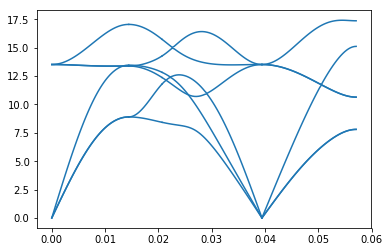

In [12]:
dblue = '#1f77b4'

offset = 0
for ii, band in enumerate(bands):
    dq = la.norm(band[1] - band[0])
    xs = dq * np.linspace(0, 1, len(band)) + offset
    offset = max(xs)
    plt.plot(xs, dispersions[ii], color=dblue)

In [13]:
# with HarmonicAnalysis:
get_freq(ha.get_Dq(q)), ha.omegas([q]) * omega_to_THz

(array([ 8.42442216, 11.79445968, 12.36970708, 12.82895893, 14.26691616,
        15.73694375]),
 array([[ 8.42442216, 11.79445968, 12.36970708, 12.82895893, 14.26691616,
         15.73694375]]))